# Predicting wine quality

This problem deals with predicting red wine quality. Picking up good wines takes professional sommelier a lot of knowledge and experience, they say. Let us see if ML can do this job.

The [data](https://archive.ics.uci.edu/ml/datasets/wine+quality) for this problem are the results of a chemical analysis of vinho verde wine samples, from the north of Portugal. Your goal is to predict wine quality based on physicochemical tests. 

Attributes of the data are:

* fixed acidity 
* volatile acidity 
* citric acid 
* residual sugar 
* chlorides 
* free sulfur dioxide 
* total sulfur dioxide 
* density 
* pH 
* sulphates 
* alcohol 
* quality (score between 0 and 10)

### Exploring the data

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import csv
import sklearn
from sklearn.metrics import confusion_matrix

import xgboost as xgb

%matplotlib inline

Load the data from `wine_data.csv`. If there are any missing values or non-numerical features, fix them.

In [2]:
data = pd.read_csv("wine_data.csv", sep=";")
data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [3]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [4]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
data["quality"].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Now we can see that the data is not balanced so `balansed_accuracy_score` will be used for measuring the success of a model further on.

### Preparing the subsets

Split the dataset into three subsets: train, CV and test using 60-20-20% rule. Keep wine quality separately as a label we want to predict.

In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2)
train_set, cv_set = train_test_split(train_set) #default test_size=0.25|*0.8 = 0.2

train_y = train_set["quality"]
del train_set["quality"]

cv_y = cv_set["quality"]
del cv_set["quality"]

test_y = test_set["quality"]
del test_set["quality"]

# test_y.head(10)
# test_y.unique()

### Training logistic regression

Train logistic regression to classify the wine. Use scikit-learn implementation of this model. Tweak the hyperparameters of the model to get the maximum performance on CV set.

In [8]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(C=10).fit(train_set, train_y) #C=1/lambda - weight decay hp

/home/maryana/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/maryana/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [9]:
lr_train_predicted = log_clf.predict(train_set)
lr_cv_predicted = log_clf.predict(cv_set)
lr_test_predicted = log_clf.predict(test_set)

In [10]:
from sklearn.metrics import balanced_accuracy_score

train_log_score = balanced_accuracy_score(train_y, lr_train_predicted)
cv_log_score = balanced_accuracy_score(cv_y, lr_cv_predicted)
test_log_score = balanced_accuracy_score(test_y, lr_test_predicted)

print(train_log_score, cv_log_score, test_log_score)

0.267584172491984 0.22212018596108593 0.23538655374567719


### Training SVM

Train support vector machines to classify the wine. Use scikit-learn implementation of this model. Tweak the hyperparameters of the model to get the maximum performance on CV set.

Keep the model and the results separate from the logistic regression. You will need them for comparing the performance of the models.

In [32]:
from sklearn.svm import SVC
svm_clf = SVC(C=10000, kernel="rbf", gamma=0.001).fit(train_set, train_y)
# small C - max distance to the hyperplane, big - less errors
# rbf - normal curve kernel
# gamma - inverse of the standard deviation of the curve

In [33]:
svm_train_predicted = svm_clf.predict(train_set)
svm_cv_predicted = svm_clf.predict(cv_set)
svm_test_predicted = svm_clf.predict(test_set)

In [34]:
train_svm_score = balanced_accuracy_score(train_y, svm_train_predicted)
cv_svm_score = balanced_accuracy_score(cv_y, svm_cv_predicted)
test_svm_score = balanced_accuracy_score(test_y, svm_test_predicted)

print(train_svm_score, cv_svm_score, test_svm_score)

0.6942233055514292 0.3799093299896836 0.2846293662914024


### Training XGBoost

Train XGBoost to classify the wine. Use xgboost implementation of this model. Tweak the hyperparameters of the model to get the maximum performance on CV set.

Keep the model and the results separate from two others. You will need them for comparing the performance of the models.

In [49]:
xgb_clf = xgb.XGBClassifier( gamma=0.6, learning_rate=0.01, max_depth=19, n_estimators=300, n_jobs=8, reg_lambda=3, subsample=1)
xgb_clf.fit(train_set, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.6, learning_rate=0.01, max_delta_step=0,
       max_depth=19, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=8, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=3, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [50]:
xgb_train_predicted = xgb_clf.predict(train_set)
xgb_cv_predicted = xgb_clf.predict(cv_set)
xgb_test_predicted = xgb_clf.predict(test_set)

In [51]:
train_xgb_score = balanced_accuracy_score(train_y, xgb_train_predicted)
cv_xgb_score = balanced_accuracy_score(cv_y, xgb_cv_predicted)
test_xgb_score = balanced_accuracy_score(test_y, xgb_test_predicted)

print(train_xgb_score, cv_xgb_score, test_xgb_score)

0.6969635983099032 0.31882186381985494 0.3227200482945759


### Plotting confusion matrices

Confusion matrix is a useful tool to understand what errors the models make. This code plots confusion matrices on CV set for all three models you have trained. These can help you with tweaking hyperparameters of the models as well.

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 0  0  2  0  0  0]
 [ 0  0  9  4  0  0]
 [ 0  0 94 39  0  0]
 [ 0  0 47 82  2  0]
 [ 0  0  4 34  0  0]
 [ 0  0  0  2  1  0]]
Confusion matrix, without normalization
[[ 1  0  1  0  0  0]
 [ 0  2  9  2  0  0]
 [ 1  6 87 39  0  0]
 [ 0  1 43 79  8  0]
 [ 0  2  2 20 14  0]
 [ 0  0  0  2  1  0]]
Confusion matrix, without normalization
[[ 0  0  2  0  0  0]
 [ 0  0  9  4  0  0]
 [ 0  1 97 34  1  0]
 [ 0  2 31 93  5  0]
 [ 0  0  1 19 18  0]
 [ 0  0  0  1  2  0]]


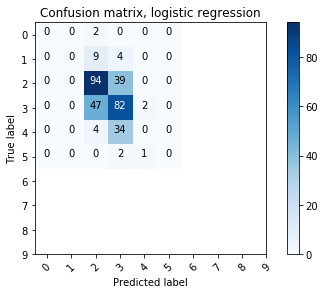

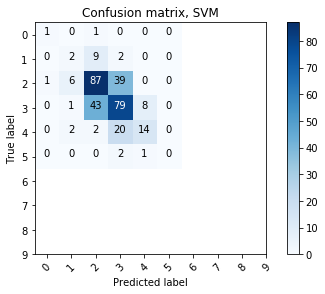

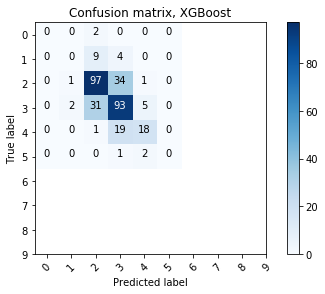

In [53]:
np.set_printoptions(precision=2)
class_names = range(10)

# Plot non-normalized confusion matrix for logistic regression
lr_cnf_matrix = confusion_matrix(cv_y, lr_cv_predicted)
plt.figure()
plot_confusion_matrix(lr_cnf_matrix, classes=class_names,
                      title='Confusion matrix, logistic regression')

# Plot non-normalized confusion matrix for SVM
svm_cnf_matrix = confusion_matrix(cv_y, svm_cv_predicted)
plt.figure()
plot_confusion_matrix(svm_cnf_matrix, classes=class_names,
                      title='Confusion matrix, SVM')

# Plot non-normalized confusion matrix for XGBoost
xgb_cnf_matrix = confusion_matrix(cv_y, xgb_cv_predicted)
plt.figure()
plot_confusion_matrix(xgb_cnf_matrix, classes=class_names,
                      title='Confusion matrix, XGBoost')

### Check test set performance

Now, check the accuracy of all three models on the test set and compare it with the CV test accuracy. Explain the results.

In [54]:
print(test_log_score, test_svm_score, test_xgb_score)
print(cv_log_score, cv_svm_score, cv_xgb_score)

0.23538655374567719 0.2846293662914024 0.3227200482945759
0.22212018596108593 0.3799093299896836 0.31882186381985494


xgboost and svm seem to work better than LogRegression. We need to know more about hyperparameters to increase the success of our models.